In [4]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

     Plan ID Contract Number  allow_o0013
0        001           H0084        32039
1        001           H0141         9799
2        001           H0150       228622
3        001           H0151       322807
4        001           H0154       230562
...      ...             ...          ...
3367     840           R5826          600
3368     841           R5826          599
3369     842           R5826          600
3370     843           R5826          599
3371     844           R5826          599

[3372 rows x 3 columns]
year: 2012
399827172 156229667
(3372, 3) (4146, 10)
(2780, 11)
2780 56372.01258992806 55592.02410071943 779.988489208633 62813.21097227463 11215.907194244604


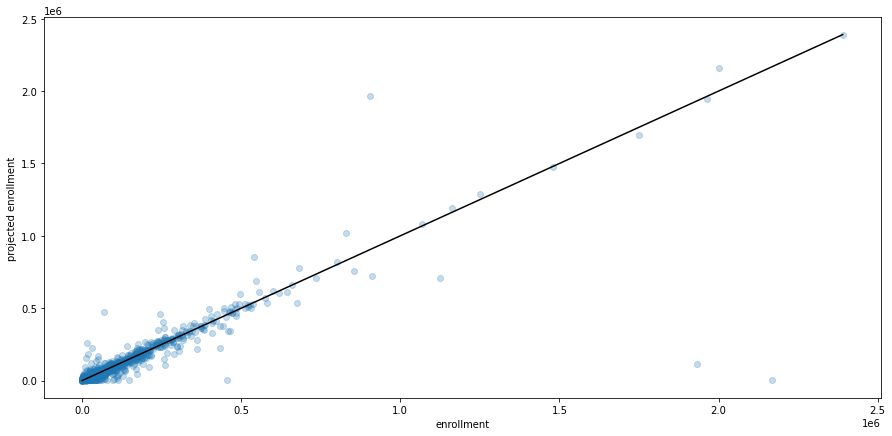

Enrollment     156714195
allow_o0013    154545827
dtype: int64
---
     Plan ID Contract Number  allow_o0013
0        001           H0029         5927
1        001           H0062         8490
2        001           H0088         1864
3        001           H0111        39744
4        001           H0169        18220
...      ...             ...          ...
2843     268           H1036         4720
2844     269           H1036        21089
2845     270           H1036         5800
2846     271           H1036         4602
2847     274           H1036         6061

[2848 rows x 3 columns]
year: 2018
561249354 195464750
(2848, 3) (4326, 10)
(2799, 11)
2799 68768.85887817078 69778.2826009289 -1009.423722758128 19915.14695004284 8553.034297963559


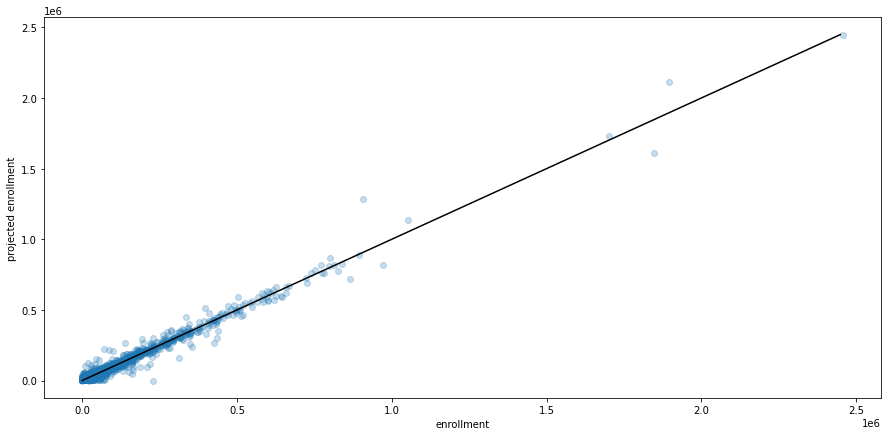

Enrollment     192484036
allow_o0013    195309413
dtype: int64
---


In [5]:
def read_enroll_files(year,month):
    name = '../data/Monthly_Report_By_Plan_%s_%s/Monthly_Report_By_Plan_%s_%s.csv'%(year,month,year,month)
    file = open(name,'r',encoding = "ISO-8859-1")
    lines = file.readlines()

    count = 0
    end_loop = 0
    
    #iterate until we find the header
    while end_loop == 0:    
        if 'Contract' in lines[count] and 'Enrollment' in  lines[count]:
            end_loop = 1
        count += 1
    file.close()
    data = pd.read_csv(name,skiprows=count-1, on_bad_lines='skip',encoding = "ISO-8859-1")
    return data

def read_bid_data(year):
    name = '../data/BPT%s_data/ma_2.txt'%(year)
    data = pd.read_csv(name, on_bad_lines='skip',encoding = "ISO-8859-1",delimiter='\t')
    data['Contract Number'] = data['bid_id'].apply(lambda x : x[:5])
    data['Plan ID'] = data['bid_id'].apply(lambda x : x[6:9])
    data = data[data['allow_o0013']!='*'] 
    data['allow_o0013'] = data['allow_o0013'].astype('int')  
    return data[['Contract Number','Plan ID','allow_o0013']]


wrong_insurers = []
for year in [2012,2018]:
    year_file = read_enroll_files(year,'01')
    for month in range(2,13):
        #pad month name
        month_name = str(month).zfill(2)
        month_file = read_enroll_files(year,month_name)
        year_file = pd.concat([year_file,month_file])
    
    #group by plan/bid
    year_file['Year'] = year
    year_file = year_file [~year_file['Plan ID'].isna()]
    year_file = year_file [year_file['Enrollment']!='*']
    year_file['Enrollment'] = year_file['Enrollment'].astype('int')
    year_file['Plan ID'] = year_file['Plan ID'].apply(lambda x : str(int(x)).zfill(3) )
    year_file_group = year_file.groupby(
        ['Plan ID','Contract Number'],as_index=False).agg({'Enrollment':'sum','Organization Type':'first',
                                                          'Plan Type':'first','Offers Part D':'first',
                                                           'Organization Name':'first',
                                         'Organization Marketing Name':'first','Plan Name':'first',
                                         'Parent Organization':'first'})
    
    
    #group year bids by service area
    year_bids = read_bid_data(year)  
    year_bids_group = year_bids.groupby(['Plan ID','Contract Number'],as_index=False)['allow_o0013'].sum()
    print(year_bids_group)
    
    #join the 2
    print('year: %s'%year)
    print(year_file_group['Enrollment'].sum(),year_bids_group['allow_o0013'].sum())
    print(year_bids_group.shape,year_file_group.shape)
    merge = year_file_group.merge(year_bids_group,how='inner',on =['Plan ID','Contract Number'])
    print(merge.shape)

    sq_error = np.sqrt( ((merge['allow_o0013'] - merge['Enrollment'])**2 ).mean() ) 
    abs_error = ( np.sqrt( (merge['allow_o0013'] - merge['Enrollment'])**2) ).mean()
    error = ( (merge['Enrollment']- merge['allow_o0013'] ) ).mean()
    #https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error
    print(merge['allow_o0013'].count(),merge['Enrollment'].mean(),merge['allow_o0013'].mean(), error, sq_error, abs_error)
    
    #make a plot with the actual results    
    plt.figure(figsize=(15,7))
    max_plot = int(merge['allow_o0013'].max())
    plt.plot(range(0,max_plot),range(0,max_plot),color='black')
    plt.scatter(merge['Enrollment'],merge['allow_o0013'],alpha=.25)
    plt.xlabel('enrollment')
    plt.ylabel('projected enrollment')
    plt.show()
    
    abs_error_per_plan = np.abs(merge['Enrollment'] - merge['allow_o0013'])
    print(merge[['Enrollment','allow_o0013']].sum())
    wrong_insurers.append(merge)
    
    print('---')
    


In [14]:
#get some stats on the bad insurers

for i in range(2):
    merge_info = wrong_insurers[i].copy()

    
    #merge_info = wrong_insurers[i][['Plan ID','Contract Number','allow_o0013']].merge(year_file,how='left',
                                                                            #on=['Plan ID','Contract Number'])
    merge_info['error'] = merge_info['allow_o0013'] - merge_info['Enrollment']
    #print(merge_info['allow_o0013'][merge_info['Organization Name']=='UNITEDHEALTHCARE INSURANCE COMPANY'].sum(),
    #      merge_info['Enrollment'][merge_info['Organization Name']=='UNITEDHEALTHCARE INSURANCE COMPANY'].sum())
    
    merge_info['employer'] = merge_info['Plan Name'].apply(lambda x : 'Employer' in x) 
    print(merge_info['employer'].sum())
    merge_info['employer'] = merge_info['employer'] | merge_info['Plan Name'].apply(lambda x : 'EGWP' in x) 
    print(merge_info.groupby('employer').agg({'Plan ID':'count', 'error':'sum','Enrollment':'sum'}).sort_values(by='error'))
    
    print(merge_info[['allow_o0013','Enrollment']].sum())
    print('---')
    print(merge_info.groupby('Plan Type').agg({'Plan ID':'count', 'error':'sum','Enrollment':'sum'}).sort_values(by='error'))
    print('---')
    print(merge_info.groupby('Plan Type').agg({'Plan ID':'count', 'error':'sum','Enrollment':'sum'}).sort_values(by='error',ascending=False))
    print('---')
    print(merge_info.groupby('Organization Name').agg({'Plan ID':'count', 'error':'sum','Enrollment':'sum'}).sort_values(by='error').head(10) )
    print('---')
    print(merge_info.groupby('Organization Name').agg({'Plan ID':'count', 'error':'sum','Enrollment':'sum'}).sort_values(by='error',ascending=False).head(10) )
    print('---')
    print(merge_info.columns)
    #print(merge_info.groupby('UNITEDHEALTHCARE OF NORTH CAROLINA, INC.')['Plan ID'].count() )

144
          Plan ID    error  Enrollment
employer                              
True          152 -2803688     9526162
False        2628   635320   147188033
allow_o0013    154545827
Enrollment     156714195
dtype: int64
---
                                          Plan ID    error  Enrollment
Plan Type                                                             
Local PPO                                     682 -4179255    34663598
Employer/Union Only Direct Contract PFFS        1    -3926      145154
HMO                                          1477    49735    86454863
PSO (State License)                             7    86364      424339
Regional PPO                                  102   287706    11497823
PFFS                                          196   750254     6176724
HMOPOS                                        315   840754    17351694
---
                                          Plan ID    error  Enrollment
Plan Type                                                  

In [45]:
for plan in ['BLUE CROSS BLUE SHIELD OF MICHIGAN','BLUE CROSS AND BLUE SHIELD OF NORTH CAROLINA']:
    #was there are mistake in 2011?
    data_2012 = wrong_insurers[0].copy()
    data_2011 = read_bid_data(year)
    data_2011 = data_2011.groupby(['Plan ID','Contract Number'],as_index=False)['allow_o0013'].sum()

    lag_merge = data_2011.merge(data_2012,how='inner',on =['Plan ID','Contract Number'])
    lag_merge =   lag_merge[lag_merge['Organization Name']==plan]
    print(lag_merge[['Plan ID','Contract Number','Plan Type','Plan Name']])
    enroll_2012 = lag_merge['allow_o0013_y']
    enroll_2011 = lag_merge['allow_o0013_x']
    print(enroll_2012.sum() ,enroll_2011.sum(), ((enroll_2012 - enroll_2011).sum()) /enroll_2012.sum())
    actual_2012 = lag_merge['Enrollment']
    print(actual_2012.sum() ,enroll_2012.sum(), ((enroll_2012 - actual_2012).sum()) /actual_2012.sum())

    Plan ID Contract Number  Plan Type                               Plan Name
130     001           H9572  Local PPO  Medicare Plus Blue PPO Signature (PPO)
204     002           H9572  Local PPO   Medicare Plus Blue PPO Vitality (PPO)
245     003           H9572  Local PPO     Medicare Plus Blue PPO Assure (PPO)
710295 819511 -0.15376146530666834
646760 710295 0.09823582163399097
    Plan ID Contract Number Plan Type                             Plan Name
303     005           H3449       HMO      Blue Medicare HMO Enhanced (HMO)
460     012           H3449       HMO  Blue Medicare HMO Medical Only (HMO)
275100 307765 -0.11873864049436568
500864 275100 -0.45074910554561715


In [46]:
for geo_name in ['MICHIGAN','NORTH CAROLINA']:
    #was there are mistake in 2011?
    data_2012 = wrong_insurers[0].copy()
    
    filter_merge = data_2012['Organization Name'].apply(lambda x : geo_name in x )
    lag_merge = data_2012[filter_merge]
    print(lag_merge[['Plan ID','Contract Number','Organization Name','Plan Name','Plan Type',]])
    enroll_2012 = lag_merge['allow_o0013']
    #enroll_2011 = lag_merge['allow_o0013_x']
    actual_2012 = lag_merge['Enrollment']
    #print(enroll_2012.sum() ,enroll_2011.sum(), ((enroll_2012 - enroll_2011).sum()) /enroll_2012.sum())
    print(actual_2012.sum() ,enroll_2012.sum(), ((enroll_2012 - actual_2012).sum()) /actual_2012.sum())

     Plan ID Contract Number                       Organization Name  \
1        001           H0141                     CARESOURCE MICHIGAN   
78       001           H2354                  HEALTHPLUS OF MICHIGAN   
223      001           H5475  MERIDIAN HEALTH PLAN OF MICHIGAN, INC.   
261      001           H5883           BLUE CARE NETWORK OF MICHIGAN   
263      001           H5926           MOLINA HEALTHCARE OF MICHIGAN   
323      001           H9572      BLUE CROSS BLUE SHIELD OF MICHIGAN   
487      002           H5883           BLUE CARE NETWORK OF MICHIGAN   
488      002           H5926           MOLINA HEALTHCARE OF MICHIGAN   
525      002           H9572      BLUE CROSS BLUE SHIELD OF MICHIGAN   
630      003           H5883           BLUE CARE NETWORK OF MICHIGAN   
660      003           H9572      BLUE CROSS BLUE SHIELD OF MICHIGAN   
694      004           H2312        HEALTH ALLIANCE PLAN OF MICHIGAN   
766      004           H5883           BLUE CARE NETWORK OF MICH